# Tensorflow Object Recognition in Digital Adverts

Setup link/guide:
https://www.tensorflow.org/hub/tutorials/object_detection#setup

## Functions

In [1]:
# !pip install tensorflow
# !pip install tensorflow_hub
# !pip install opencv-python

In [2]:
# For using the tensorflow object detection cnn
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time


# For finding dominant colour
import cv2
import numpy as np

# For converting colour to name
from scipy.spatial import KDTree

In [3]:
# tensorflow model for object detection

# request model from web
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# pre downloaded model
# module_handle_local = r"C:\Users\PATH\faster_rcnn_openimages_v4_inception_resnet_v2_1"

# load the tensorflow detection model
detector = hub.load(module_handle).signatures['default']
# detector = hub.load(module_handle_local).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


You are able to load the tensorflow model in three ways:
- Load from url (https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1)
- Download above model and load from local machine
- Load from Google Storage Bucket (see link below)

https://stackoverflow.com/questions/60578801/how-to-load-tf-hub-model-from-local-system

In [4]:
# def download_and_resize_image(url, new_width=256, new_height=256, display=False):
#     ''' Download image from web and resize it '''
#     _, filename = tempfile.mkstemp(suffix=".jpg")
#     response = urlopen(url)
#     image_data = response.read()
#     image_data = BytesIO(image_data)
#     pil_image = Image.open(image_data)
#     pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
#     pil_image_rgb = pil_image.convert("RGB")
#     pil_image_rgb.save(filename, format="JPEG", quality=90)
#     print("Image downloaded to %s." % filename)
#     if display:
#       display_image(pil_image)
#     return filename

def display_image(image):
    fig = plt.figure(figsize=(10, 7),dpi=100)
    plt.axis(False)
    plt.imshow(image)
    plt.show()


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=2, display_str_list=()):
    """ Adds a bounding box to an image """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
      text_width, text_height = font.getsize(display_str)
      margin = np.ceil(0.05 * text_height)
      draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                      (left + text_width, text_bottom)],
                    fill=color)
      draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
      text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """ Overlay labeled boxes on an image with formatted scores and label names and returns scores """
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    score_list = []
    for i in range(min(boxes.shape[0], max_boxes)):
      if scores[i] >= min_score:
        object_name = class_names[i].decode('ascii')
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        display_str = "{}: {}%".format(object_name, int(100 * scores[i]))
        color = colors[hash(class_names[i]) % len(colors)]
        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        draw_bounding_box_on_image( image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
        score_list.append([object_name, scores[i], [ymin,xmin,ymax,xmax]]) # list for object classification accuracy and coordinates
    return image, score_list
  
  
def load_img(path):
    ''' Loads and returns image from path on system '''
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img


In [5]:
def run_detector(detector, path, display_detection=True):
    ''' Loads image from path and runs object detection '''
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    # start_time = time.time()
    result = detector(converted_img)
    # end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}
    # print("Found %d objects." % len(result["detection_scores"]))
    # print("Inference time: ", end_time-start_time)

    image_with_boxes, score_list = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])

    if display_detection:
        display_image(image_with_boxes)
    
    return score_list # returns [object, score, crop_coordinates]

In [6]:
def get_crop_coords(object, scores):
    ''' Returns crop coordinates for desired object '''
    for i in range(len(scores)):
        if scores[i][0] == str(object).capitalize():
            return scores[i][2]
        
    print('Object not recognised') # prints error message if object not in scores list
    return

In [7]:
def crop_image(image_path, object, scores, display_crop=False):
    ''' Crops image based on object detection box '''
    crop_coords = get_crop_coords(object, scores)
    im = Image.open(image_path)
    im_width, im_height = im.size

    ymin, xmin, ymax, xmax = crop_coords
    left, right, top, bottom = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    
    extra_vertical_crop = (bottom-top)*0.30 # reducing vertical pixels by 30%
    extra_horizontal_crop = (right-left)*0.05 # reducing horizontal pixels by 5%

    img_crop = im.crop((left+extra_horizontal_crop, top+extra_vertical_crop, 
                        right-extra_horizontal_crop, bottom-extra_vertical_crop))
    
    if display_crop == True:
        display_image(img_crop)
        
    return img_crop # returns cropped image

In [8]:
def find_dominant_colour(image_path, object, scores, resize, display_resize=False, display_col=False, display_crop=False):
    ''' Finds dominant colour in image '''
    pil_im = crop_image(image_path, object, scores, display_crop)
    
    im_width, im_height = pil_im.size
  
    # resize to max pixels based on resize value
    denominator = min(im_width, im_height)
    img_crop_resize = pil_im.resize((int((im_width/denominator)*resize), int((im_height/denominator)*resize)), resample=0)

    # convert to array and get pixels
    img = np.array(img_crop_resize)
    pixels = np.float32(img.reshape(-1, 3))

    # set number of bins/colours and do kmeans clustering for nearest match
    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    dominant = palette[np.argmax(counts)]
    
    if display_resize:
        display_image(img_crop_resize)
    
    if display_col:        
        display_colour(tuple([int(i) for i in dominant]))
    
    return dominant # returns dominant colour in rgb format
    

In [9]:
def display_colour(colour, size=3):
    ''' displays colour in 3x3 grid '''
    fig = plt.figure(figsize=(size, size),dpi=100)
    plt.imshow([[colour]])
    plt.axis('off')
    plt.show()

def rgb_to_hsv(rgb_tuple):
    ''' Converts rgb to hsv '''
    r, g, b = rgb_tuple[0]/255.0, rgb_tuple[1]/255.0, rgb_tuple[2]/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100 # saturation as percentage
    v = mx*100  # value as percentage
    return (round(h), round(s), round(v))

def hsv_sat_boost(hsv_tuple):
    ''' Boosts saturation value of hsv colour '''
    hsv_tuple = list(hsv_tuple)
    
    # preserves saturation for white and grey colours
    if hsv_tuple[1] >= 20:
        hsv_tuple[1] = 100
    
    return tuple(hsv_tuple)

def hsv_to_rgb(hsv_tuple):
    ''' Converts hsv to rgb based on formula '''
    h, s, v = hsv_tuple[0], hsv_tuple[1]/100, hsv_tuple[2]/100
    c = v * s
    x = c * (1 - abs(((h/60) % 2) - 1))
    m = v - c
    
    if 0 <= h < 60:
        r_ = c
        g_ = x
        b_ = 0
    
    elif 60 <= h < 120:
        r_ = x
        g_ = c
        b_ = 0
        
    elif 120 <= h < 180:
        r_ = 0
        g_ = c
        b_ = x
    
    elif 180 <= h < 240:
        r_ = 0
        g_ = x
        b_ = c
        
    elif 240 <= h < 300:
        r_ = x
        g_ = 0
        b_ = c
        
    elif 300 <= h < 360:
        r_ = c
        g_ = 0
        b_ = x
        
    rgb = ((round((r_ + m)*255), round((g_ + m)*255), round((b_ + m)*255)))
    
    return rgb

def preprocess_rgb(rgb_tuple):
    ''' Combines functions above to boost rgb saturation '''
    return hsv_to_rgb(hsv_sat_boost(rgb_to_hsv(rgb_tuple)))

In [10]:
def colour_names():
    ''' list of colour names for matching '''
    
    return    { "white"         :(255,255,255),        
                "gray"          :(128,128,128), 
                # "silver"        :(192,192,192),  
                "black"         :(0,0,0),  
                "maroon"        :(80,0,0), # changed from 128 to 80
                "red"           :(200,0,0),      
                "orange"        :(255,130,0),    
                "yellow"        :(199,136,0),
                "bright_yellow" :(255,255,0),   
                "lime"          :(0,255,0),      
                "green"         :(0,80,0),      
                "olive"         :(128,128,0),    
                # "teal"          :(0,128,128),    
                "navy_blue"     :(0,0,60),      
                "blue"          :(0,0,200),      
                "aqua"          :(0,200,200),    
                "fuchsia"       :(255,0,255),    
                "purple"        :(60,0,60) }

def convert_rgb_to_names(rgb_tuple):
    ''' Converts a given rgb tuple to English name'''
    
    colour_list =  colour_names()
    names = list(colour_list.keys())
    rgb_values = list(colour_list.values())
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple) # finding closest colour match 
    
    return names[index] # returns colour name

In [11]:
def show_colour_list():
    ''' Displays list of colours '''
    colour_list = colour_names()
     
    fig, axes = plt.subplots(1,len(colour_list), sharex=True, sharey=True, figsize=(18,2), dpi=300)
    c_list = list(colour_list.keys())

    for i, ax in enumerate(axes.flat):
        ax.imshow([[colour_list[c_list[i]]]])
        ax.axis('off')
        ax.title.set_text(str(c_list[i]).capitalize())
        
    fig.tight_layout()
    plt.show()

In [12]:
def guess_colour(path, object, detector, resize=40, display_detection=False, display_resize=False, display_col=False, display_crop=False, display_sat_boost_col=False):
    ''' Returns predicted colour of object and its English name '''
    scores = run_detector(detector, path, display_detection)
    prediction = find_dominant_colour(path, object, scores, resize, display_resize, display_col, display_crop)
    preprocess_prediction = preprocess_rgb(prediction)
    
    if display_sat_boost_col:
        display_colour(preprocess_prediction)
    
    return preprocess_prediction, convert_rgb_to_names(preprocess_prediction)
    

## Examples

Below is the full list of colours that the function will attempt to match to.

Useful link for visualising colours - 
https://www.color-blindness.com/color-name-hue/

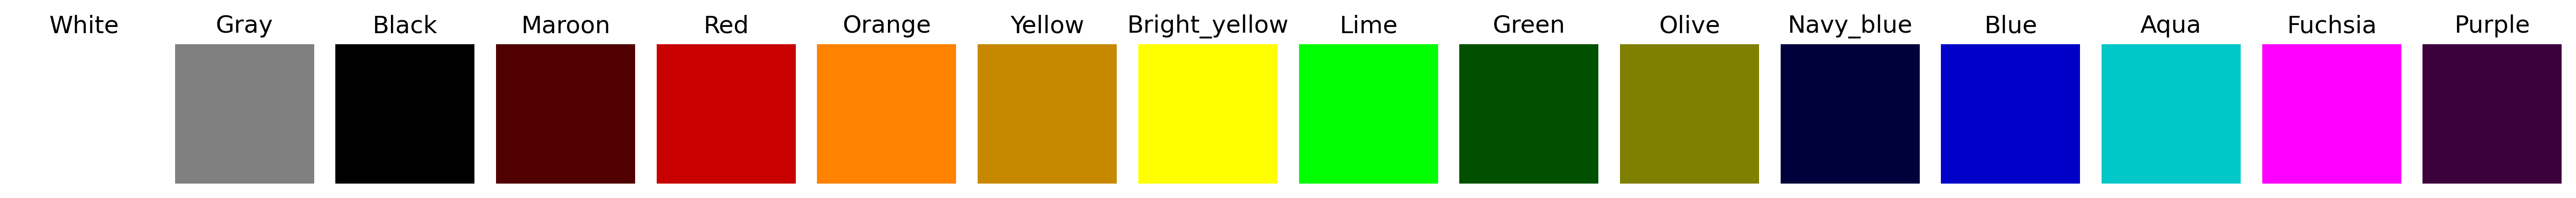

In [13]:
show_colour_list()

In the examples below the code runs in the following steps:
1. Image is loaded and tensorflow object detection cnn (convolutional neural network) is run
2. The image is cropped to the detection box
3. This is then cropped further to remove unnecessary pixel around the edge
4. It is then resized to a 40 pixel length image (can be adjusted as desired)
5. Colour matching is carried out
6. A colour in rgb format and its closest English name is returned

Below is an explanation of some of the extra display parameters:
- If display_detection is set to True, the image is displayed with detection boxes overlayed
- If display_crop is set to True, the cropped image is displayed
- If display_col is set to True, the initial colour prediction is displayed
- If display_resize is set to True, the cropped and resized image is displayed
- If display_sat_boost_col is set to True, the boosted colour is displayed

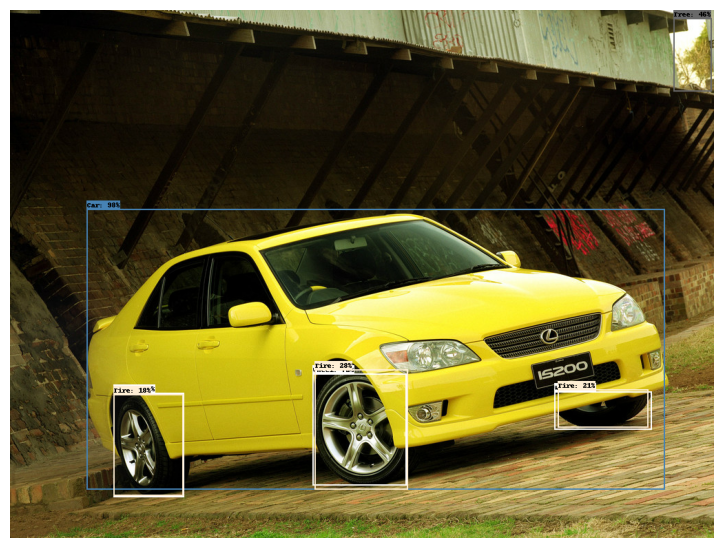

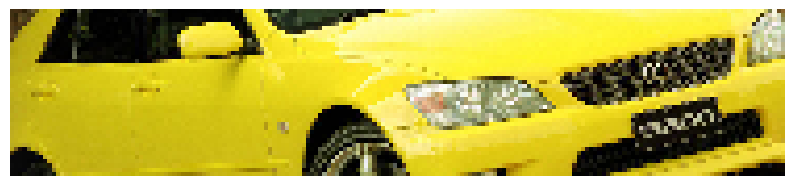

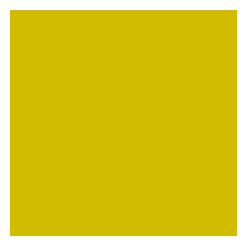

Yellow


In [14]:
is200 = r'C:\Users\ckhan\Documents\public-projects\object-detection\test-images\is200.jpg'
rgb_pred, colour_name = guess_colour(is200, 'car', detector, display_detection=True, display_crop=False, display_resize=True, display_col=False, display_sat_boost_col=True)
print(colour_name.capitalize())

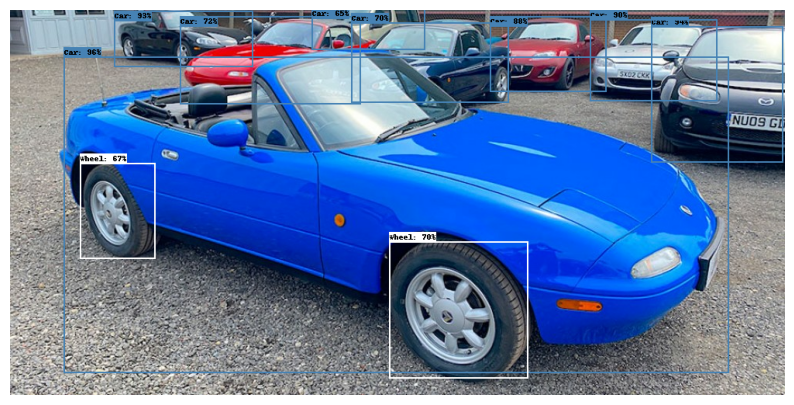

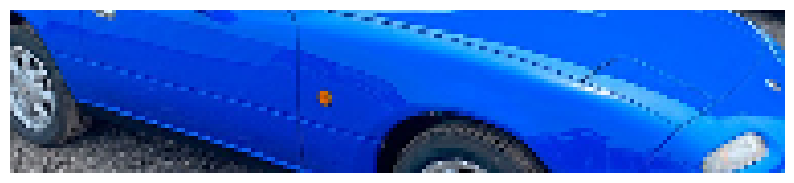

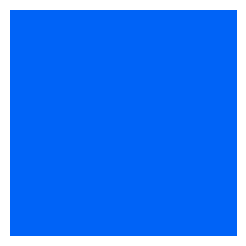

Blue


In [23]:
mx5 = r'C:\Users\ckhan\Documents\public-projects\object-detection\test-images\Mx5.jpg'
rgb_pred, colour_name = guess_colour(mx5, 'car', detector, display_detection=True, display_crop=False, display_resize=True, display_col=False, display_sat_boost_col=True)
print(colour_name.capitalize())

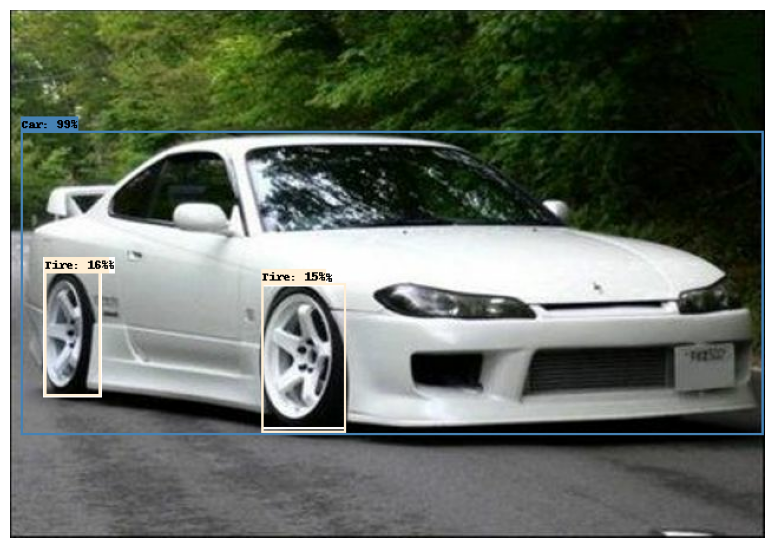

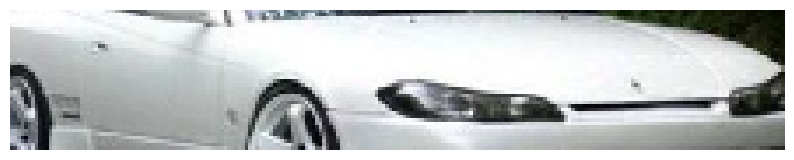

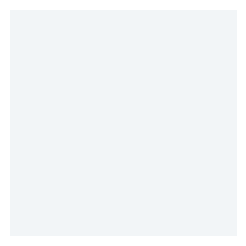

White


In [24]:
s15 = r'C:\Users\ckhan\Documents\public-projects\object-detection\test-images\s15.jpg'
rgb_pred, colour_name = guess_colour(s15, 'car', detector, display_detection=True, display_crop=False, display_resize=True, display_col=False, display_sat_boost_col=True)
print(colour_name.capitalize())

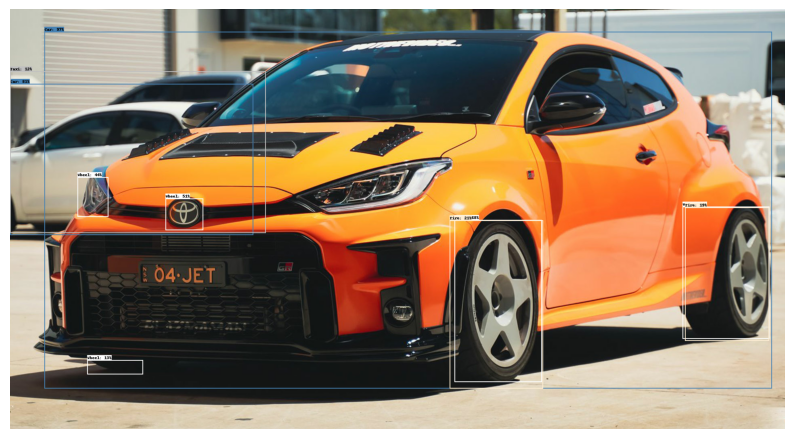

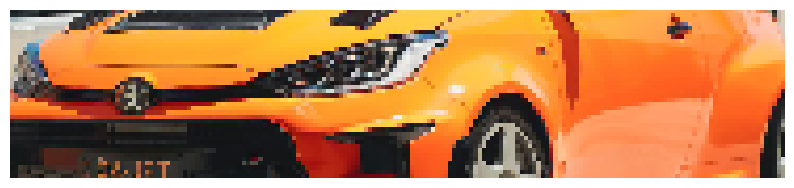

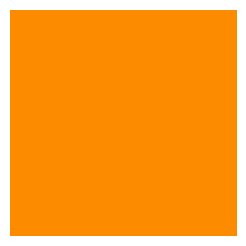

Orange


In [25]:
yarisgr = r'C:\Users\ckhan\Documents\public-projects\object-detection\test-images\yarisgr.jpg'
rgb_pred, colour_name = guess_colour(yarisgr, 'car', detector, display_detection=True, display_crop=False, display_resize=True, display_col=False, display_sat_boost_col=True)
print(colour_name.capitalize())

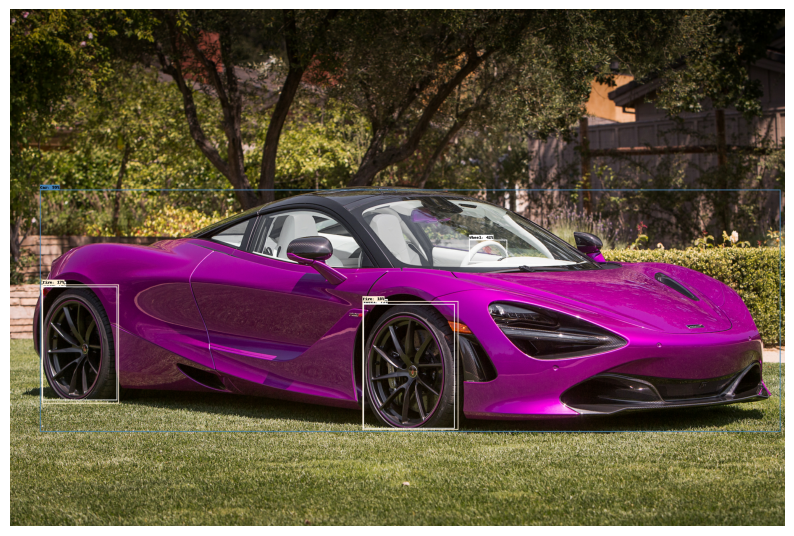

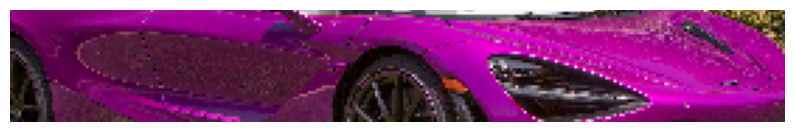

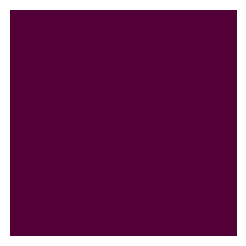

Purple


In [27]:
mclaren720s = r'C:\Users\ckhan\Documents\public-projects\object-detection\test-images\mclaren-720s.jpg'
rgb_pred, colour_name = guess_colour(mclaren720s, 'car', detector, display_detection=True, display_crop=False, display_resize=True, display_col=False, display_sat_boost_col=True)
print(colour_name.capitalize())

https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv